# Тестовое задание Product Analyst

## Задание 1

Приложение - мобильная утилита для сканирования документов. Модель монетизации подписочная, есть пробный период 7 дней с дальнейшим переходом в оплату 4.99 USD в неделю. По ссылке ниже выгрузка с базы данных по оформлениям подписок и оплат. Каждая строка представляет собой отдельное событие (либо оформление пробной подписки, либо оплата после завершения пробного периода). Задание построено таким образом, чтобы проверить понимание принципов unit-экономики предприятия. Задание 1 предпочтительней делать с помощью Python.1. Необходимо рассчитать текущий LTV юзера, используя когортный анализ
(cohorting event - оформление пробного периода, когорта представляет собой кол-во
возможных операций).
2. Спрогнозировать, каким будет LTV на полгода.
3. Построить график, который будет отображать кривую фактического LTV на
фоне кривой прогнозируемого LTV.
4. Рассчитать ROMI на 4 недели и на полгода, если стоимость привлечения
платящего пользователя 6 USD (ROMI нужно брать операционный, а не бухгалтерский,
цель: узнать как окупятся наши инвестиции).

1. Необходимо рассчитать текущий LTV юзера, используя когортный анализ
(cohorting event - оформление пробного периода, когорта представляет собой кол-во
возможных операций).
2. Спрогнозировать, каким будет LTV на полгода.
3. Построить график, который будет отображать кривую фактического LTV на
фоне кривой прогнозируемого LTV.
4. Рассчитать ROMI на 4 недели и на полгода, если стоимость привлечения
платящего пользователя 6 USD (ROMI нужно брать операционный, а не бухгалтерский,
цель: узнать как окупятся наши инвестиции).

### 1. Импорт необходимых библиотек и предобработка данных.

In [1]:
# Импортируем необходимые библиотеки

import pandas as pd
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
#Загрузим файл и преобразим его содержимое в датафрейм df

file = pd.read_excel('/Users/syuzannapetrosyan/Downloads/test case data analyst.xlsx')
df = pd.DataFrame(file)
display (df.head())

,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657


In [3]:
# Ознакомимся с типами данных в столбцах датафрейма

display (df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114200 entries, 0 to 114199
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   product_id       114200 non-null  object        
 1   quantity         114200 non-null  int64         
 2   is_trial_period  114200 non-null  bool          
 3   purchase_date    114200 non-null  datetime64[ns]
 4   user_id          114200 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(1)
memory usage: 3.6+ MB


None

Типы данных в представленном датасете корректны и соответствуют содержанию столбцов

In [4]:
# Проверим датафрейм на наличие пропусков 

display (df.isna().sum())

product_id         0
quantity           0
is_trial_period    0
purchase_date      0
user_id            0
dtype: int64

В датафрейме отсутствуют пропуски в данных. Можно проверять на наличие дубликатов

In [5]:
# Проверим датафрейм на наличие дубликатов и удалим их, если они имеются

display (df.duplicated().sum())
df = df.drop_duplicates()

84

In [6]:
# Выясним, какое количество событий может находиться в столбце quantity

display (df['quantity'].unique())

array([1])

Оказалось, что каждой строке соответствует ровно одно событие (покупка или оформление пробного периода), что облегчает нашу задачу. Теперь выясним, информацию о каком количестве уникальных пользователей содержит датафрейм

In [7]:
# Узнаем число уникальных пользователей

display (df['user_id'].nunique())

62909

Осталось понять, каким образом распределены события во времени

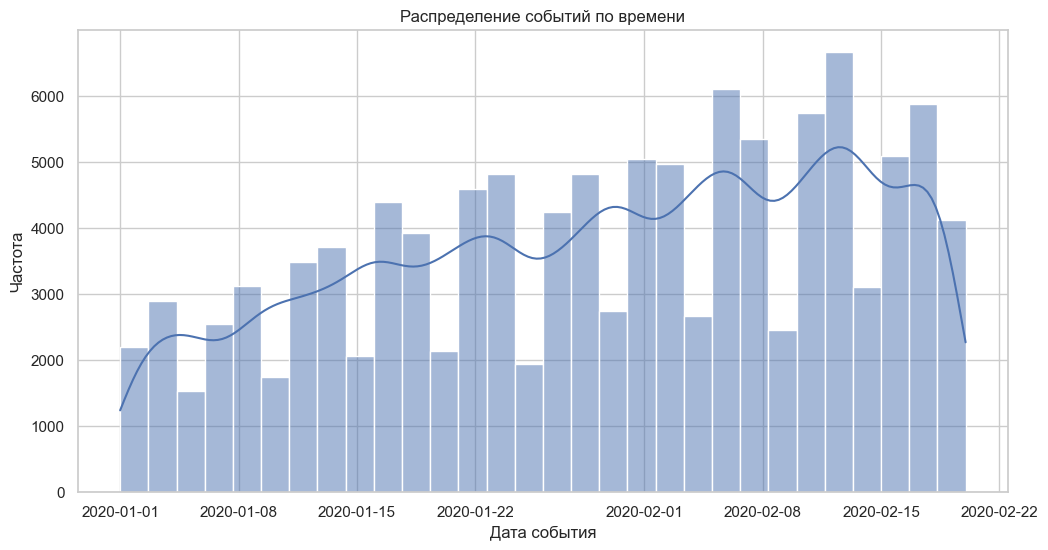

In [8]:
# Ознакомимся с распределением данных по времени совершения события


sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='purchase_date', bins=30, kde=True)

plt.title('Распределение событий по времени')
plt.xlabel('Дата события')
plt.ylabel('Частота')


plt.show();


### 2. Разделение пользователей на когорты

Для начала разделим всех пользователей на когорты по дате привлечения (оформления пробного периода).

In [9]:
# Сохраним данные об оформлении пробных периодов в отдельный датафрейм trials

trials = (df[df['is_trial_period']==True].sort_values(by = 'purchase_date'))
#display (trials)

# Выделим столбцы purchase_date и user_id в отдельный датафрейм cohort_user_df 
cohort_user_df = trials [['purchase_date', 'user_id']]
#display (cohort_user_df)

In [10]:
# Проверим, есть ли среди пользователей те, кто оформлял пробный период более одного раза

multiple_trials_users = cohort_user_df[cohort_user_df.duplicated(subset=['user_id'], keep=False)].sort_values(by='user_id')

multiple_trials_count = multiple_trials_users.groupby(
    'user_id')['purchase_date'].count().reset_index().groupby('purchase_date')['user_id'].count().reset_index()
multiple_trials_count.columns = ['count_trials', 'count_users']
display (multiple_trials_count)

,count_trials,count_users
0,2,35


In [11]:
# Сохраним в переменную users_with_multiple_trials все id пользователей, которые оформляли пробный период больше одного раза
users_with_multiple_trials = multiple_trials_users['user_id'].unique()

# Удалим из датафрейма df все строки, в которых значение в столбце user_id входит в список users_with_multiple_trials
df = df[~df['user_id'].isin(users_with_multiple_trials)]
display (df['user_id'].nunique())

62874

Теперь можно создавать когорты: для этого отсортируем все даты оформления пробных периодов по возрастанию и присвоим им порядковый номер

In [12]:
# Отсортируем все даты, в которые совершались оформления пробных периодов и сохраним их в переменную sorted_dates 
sorted_dates = sorted(trials['purchase_date'].unique())

# Присвоим каждой дате порядковый номер (он же и будет номером соответствующей когорты)
cohort_df = pd.DataFrame({'purchase_date': sorted_dates, 'cohort_number': range(1, len(sorted_dates)+1)})
display (cohort_df)
cohort_user_df = pd.merge (cohort_user_df, cohort_df, on = 'purchase_date')
cohort_user_df.columns = ['trial_date', 'user_id', 'cohort_number']

,purchase_date,cohort_number
0,2020-01-01,1
1,2020-01-02,2
2,2020-01-03,3
3,2020-01-04,4
4,2020-01-05,5
5,2020-01-06,6
6,2020-01-07,7
7,2020-01-08,8
8,2020-01-09,9
9,2020-01-10,10


In [13]:
# Добавим столбец с номером когорты и датой ее старта в датафрейм df

df = pd.merge (df, cohort_user_df, on = 'user_id', how = 'left')
df = df.sort_values(by = 'cohort_number', ascending = True)
display (df.head())

,product_id,quantity,is_trial_period,purchase_date,user_id,trial_date,cohort_number
108937,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-22,8189332,2020-01-01,1
108909,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-01,8191928,2020-01-01,1
108905,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-01,7473132,2020-01-01,1
52548,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-12,8190554,2020-01-01,1
108901,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-01,8203818,2020-01-01,1


### 3. Анализ данных по когортам

In [14]:
# Сохраним в отдельный датафрейм данные о покупках

purchases = df [df['is_trial_period']==False]
display (purchases.head())

,product_id,quantity,is_trial_period,purchase_date,user_id,trial_date,cohort_number
108937,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-22,8189332,2020-01-01,1
52548,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-12,8190554,2020-01-01,1
52585,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-15,8189653,2020-01-01,1
52624,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-22,8179571,2020-01-01,1
52629,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-05,8196529,2020-01-01,1


In [15]:
# Соберем в отдельный датафрейм result_raw данные о пользователях, когортах и событиях
result_raw = purchases [['purchase_date','user_id', 'trial_date', 'cohort_number']].copy()

# Добавим столбцец lifetime 
result_raw ['lifetime']= result_raw ['purchase_date'] - result_raw ['trial_date']

display (result_raw.head())

,purchase_date,user_id,trial_date,cohort_number,lifetime
108937,2020-01-22,8189332,2020-01-01,1,21 days
52548,2020-01-12,8190554,2020-01-01,1,11 days
52585,2020-01-15,8189653,2020-01-01,1,14 days
52624,2020-01-22,8179571,2020-01-01,1,21 days
52629,2020-02-05,8196529,2020-01-01,1,35 days


In [16]:
# Выясним, какой минимальный и максимальный лайфтайм

display(result_raw ['lifetime'].min())
display(result_raw ['lifetime'].max())

Timedelta('-47 days +00:00:00')

Timedelta('50 days 00:00:00')

Мы видим, что в датафрейме присутствуют аномальные значения: дата покупки не может быть раньше даты оформления пробного периода. Для того, чтобы иметь возможность провести анализ, необходимо удалить эти события из датафрейма.

In [17]:
# Приведем столбец с лайфтаймом к целочисленному значению
result_raw['lifetime'] = result_raw['lifetime'].dt.days
# Добавим столбец lifetime_weeks с порядковым номером недели, на которой произошло событие
result_raw['lifetime_weeks'] = np.ceil(result_raw['lifetime'] / 7).astype(int)

# Удалим строки, в которых значение лайфтайма отрицательное
result_raw = result_raw[result_raw['lifetime'] > 0]
display (result_raw.head())

,purchase_date,user_id,trial_date,cohort_number,lifetime,lifetime_weeks
108937,2020-01-22,8189332,2020-01-01,1,21,3
52548,2020-01-12,8190554,2020-01-01,1,11,2
52585,2020-01-15,8189653,2020-01-01,1,14,2
52624,2020-01-22,8179571,2020-01-01,1,21,3
52629,2020-02-05,8196529,2020-01-01,1,35,5


#### 3.1. Расчет выручки

In [18]:
# Добавим столбец со стоимостью продления подписки

result_raw ['price'] = 4.99
display (result_raw.head())

,purchase_date,user_id,trial_date,cohort_number,lifetime,lifetime_weeks,price
108937,2020-01-22,8189332,2020-01-01,1,21,3,4.99
52548,2020-01-12,8190554,2020-01-01,1,11,2,4.99
52585,2020-01-15,8189653,2020-01-01,1,14,2,4.99
52624,2020-01-22,8179571,2020-01-01,1,21,3,4.99
52629,2020-02-05,8196529,2020-01-01,1,35,5,4.99


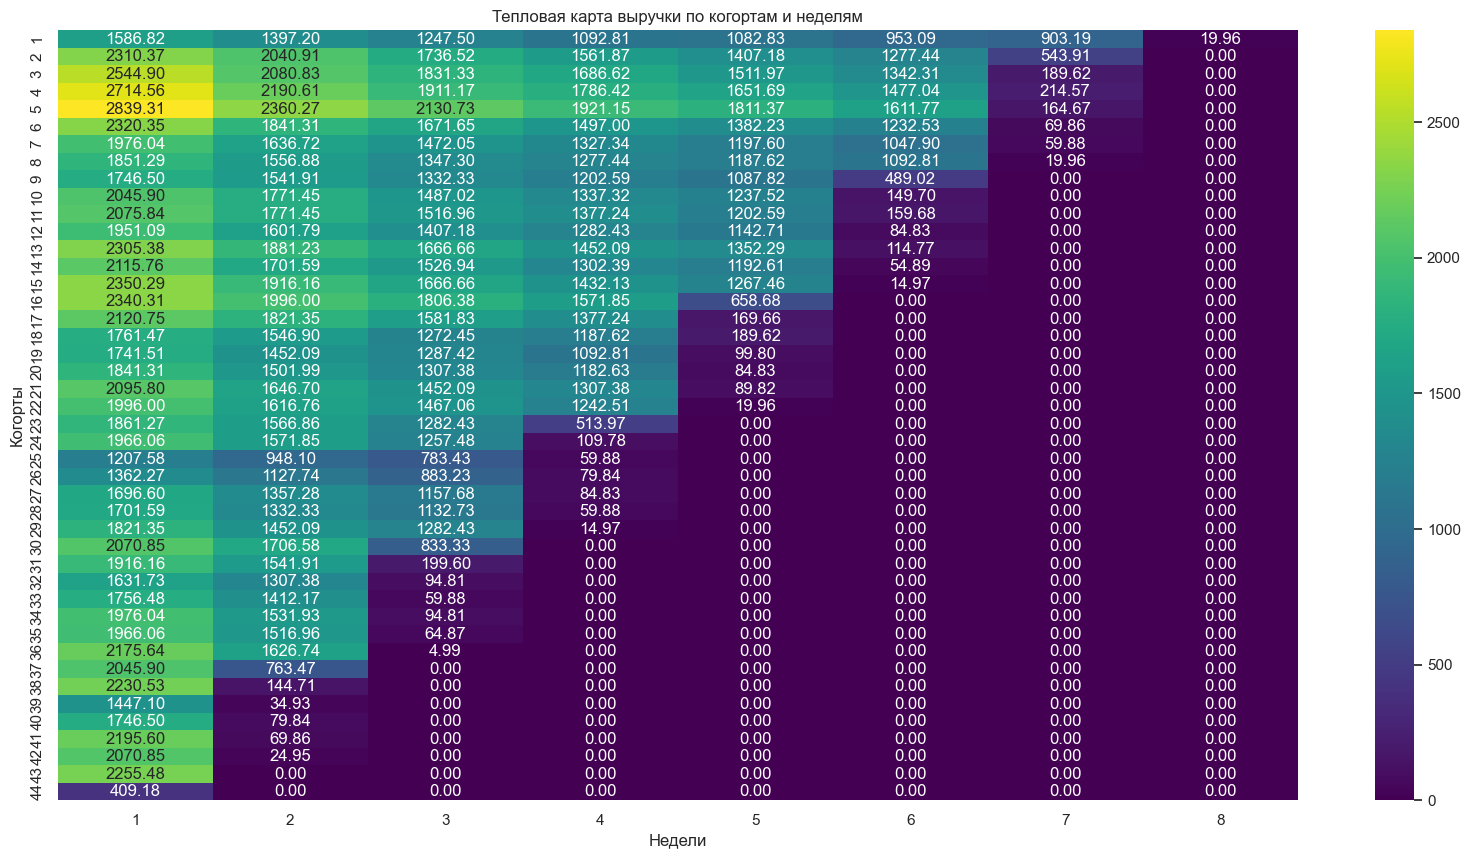

In [19]:
# Создадим сводную таблицу для расчета выручки по когортам и неделям
result_grouped = result_raw.pivot_table (index = 'cohort_number', columns = 'lifetime_weeks', values = 'price', aggfunc = 'sum')
result_grouped.fillna(0, inplace=True)

# Создадим тепловую карту
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(result_grouped, annot=True, fmt='.2f', cmap='viridis')

plt.xlabel('Недели')
plt.ylabel('Когорты')
plt.title('Тепловая карта выручки по когортам и неделям')

plt.show();

#### 3.2. Определение горизонта анализа

Для корректности анализа необходимо определить оптимальный горизонт анализа - максимальный анализируемый лайфтайм. На тепловой карте видно, что для большей части когорт рассматриваемые нами ранее 7 недель просто не успели истечь, поэтому необходимо выбрать более короткий горизонт анализа.

Чем короче горизонт анализа мы выберем, тем больше когорт сможем захватить, и наоборот.
Для целей анализа представляется оптимальным определить горизонт анализа в 4 недели - таким образом мы можем исследовать данные по первым 22 когортам.

In [20]:
# Удалим столбцы с данными по 5 неделе и далее
horizon_weeks = 4
excluded_columns = [5, 6, 7, 8]
result_grouped = result_grouped.drop (columns = excluded_columns)

# Удалим строки с данными о 23 когорте и далее
result_grouped = result_grouped.drop(result_grouped.index[-22:])
display (result_grouped)

lifetime_weeks,1,2,3,4
cohort_number,,,,
1,1586.82,1397.20,1247.50,1092.81
2,2310.37,2040.91,1736.52,1561.87
3,2544.90,2080.83,1831.33,1686.62
4,2714.56,2190.61,1911.17,1786.42
5,2839.31,2360.27,2130.73,1921.15
6,2320.35,1841.31,1671.65,1497.00
7,1976.04,1636.72,1472.05,1327.34
8,1851.29,1556.88,1347.30,1277.44
9,1746.50,1541.91,1332.33,1202.59


#### 3.3 Расчет LTV по когортам

In [21]:
# Рассчитаем выручку с накоплением по когортам

result_grouped = result_grouped.cumsum (axis = 1)
result_grouped

lifetime_weeks,1,2,3,4
cohort_number,,,,
1,1586.82,2984.02,4231.52,5324.33
2,2310.37,4351.28,6087.80,7649.67
3,2544.90,4625.73,6457.06,8143.68
4,2714.56,4905.17,6816.34,8602.76
5,2839.31,5199.58,7330.31,9251.46
6,2320.35,4161.66,5833.31,7330.31
7,1976.04,3612.76,5084.81,6412.15
8,1851.29,3408.17,4755.47,6032.91
9,1746.50,3288.41,4620.74,5823.33


In [22]:
# вычисляем размеры когорт 
cohort_sizes = result_raw.groupby('cohort_number').agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'})

# оставим только нужные нам когорты №1-22
cohort_sizes = cohort_sizes.drop(cohort_sizes.index[22:])
cohort_sizes

,cohort_size
cohort_number,
1,369
2,545
3,578
4,637
5,662
6,543
7,473
8,436
9,432


In [23]:
# объединим датафреймы cohort_sizes и result_grouped

result_grouped = cohort_sizes.merge (result_grouped, on = 'cohort_number', how = 'left').fillna (0)
display (result_grouped)

,cohort_size,1,2,3,4
cohort_number,,,,,
1,369,1586.82,2984.02,4231.52,5324.33
2,545,2310.37,4351.28,6087.80,7649.67
3,578,2544.90,4625.73,6457.06,8143.68
4,637,2714.56,4905.17,6816.34,8602.76
5,662,2839.31,5199.58,7330.31,9251.46
6,543,2320.35,4161.66,5833.31,7330.31
7,473,1976.04,3612.76,5084.81,6412.15
8,436,1851.29,3408.17,4755.47,6032.91
9,432,1746.50,3288.41,4620.74,5823.33


In [24]:
# Рассчитаем LTV для каждой когорты на протяжении 4 недель

result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)
result_grouped = result_grouped.drop (columns = 'cohort_size')
display (result_grouped)

,1,2,3,4
cohort_number,,,,
1,4.300325,8.086775,11.467534,14.429079
2,4.239211,7.984000,11.170275,14.036092
3,4.402941,8.002993,11.171384,14.089412
4,4.261476,7.700424,10.700691,13.505118
5,4.288988,7.854350,11.072976,13.975015
6,4.273204,7.664199,10.742744,13.499650
7,4.177674,7.637970,10.750127,13.556342
8,4.246078,7.816904,10.907041,13.836950
9,4.042824,7.612060,10.696157,13.479931


Итак, мы рассчитали LTV для каждой когорты на протяжении 4 недель. Для более наглядного представления построим тепловую карту и график динамики LTV по неделям

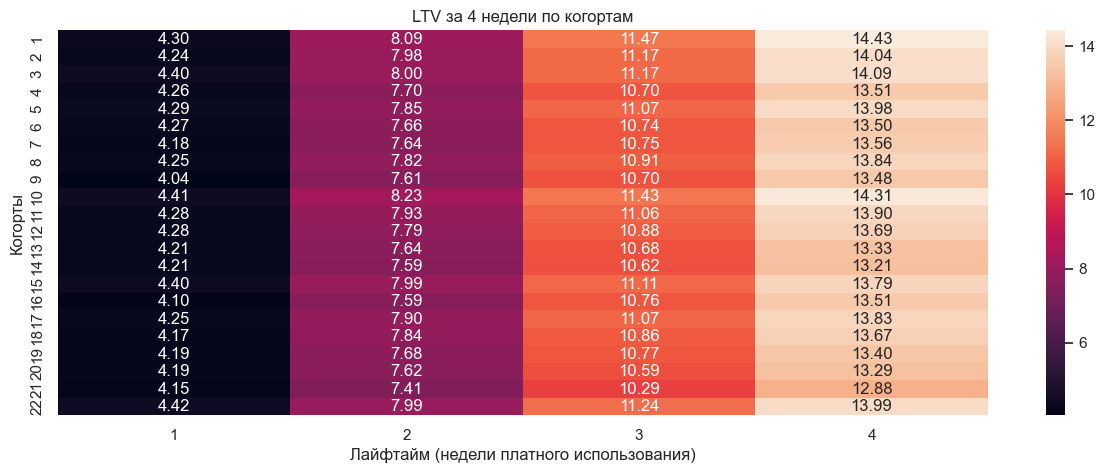

In [25]:
# Построим тепловую карту, используя данные из датафрейма result_grouped

fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap (result_grouped, annot = True, fmt = '.2f', ax = ax)

plt.xlabel ('Лайфтайм (недели платного использования)')
plt.ylabel ('Когорты')
plt.title ('LTV за 4 недели по когортам')
plt.show;

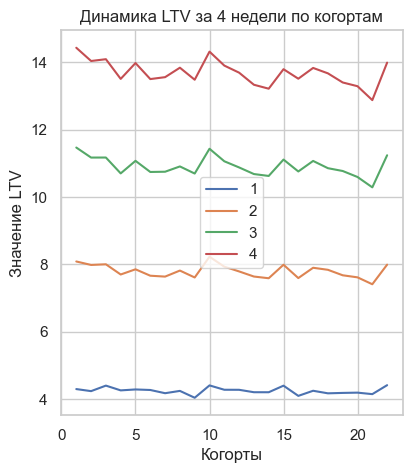

In [26]:
# Построим график динамики LTV по неделям

plt.figure(figsize=(15, 5))

result_grouped.plot (grid = True, ax = plt.subplot (1,3,3))
plt.xlabel ('Когорты')
plt.ylabel ('Значение LTV')
plt.title ('Динамика LTV за 4 недели по когортам')
plt.show();

Мы видим, что значения LTV незначительно колебались от когорте к когорте, однако в целом находились приблизительно в одном диапазоне. Для целей анализа также можем рассмотреть динамику усредненного LTV по всем когортам

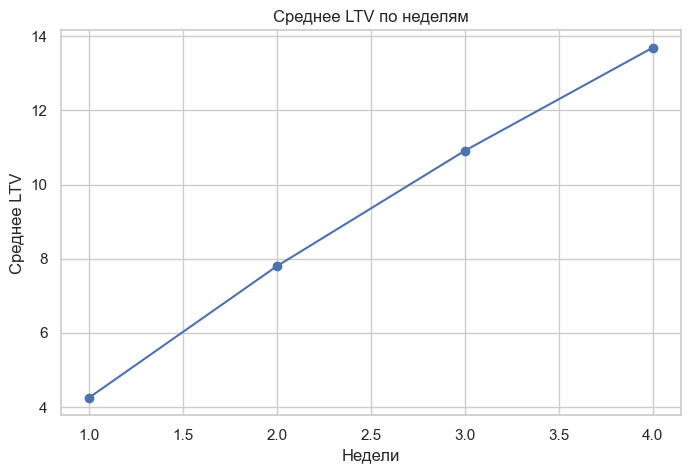

In [27]:
# Построим график среднего LTV по неделям

plt.figure(figsize=(8, 5))

plt.plot(result_grouped.mean().index, result_grouped.mean().values, marker='o', linestyle='-')
plt.xlabel('Недели')
plt.ylabel('Среднее LTV')
plt.title('Среднее LTV по неделям')

plt.show()

### 4.  Создание модели и прогнозирование LTV на ближайшие полгода 

Чтобы спрогнозировать LTV на будущее, нам необходимо создать и обучить модель на основе уже имеющихся данных

In [28]:
# Преобразование данных в формат, который можно использовать для обучения модели
X = np.arange(1, result_grouped.shape[1] + 1).reshape(-1, 1)  # Временной признак (недели)
y = result_grouped.mean(axis=0).values  # Среднее значение LTV по когортам

# Разделим данные на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

# Прогнозирование на полгода вперед
weeks_forecast = np.arange(result_grouped.shape[1] + 1, result_grouped.shape[1] + 27).reshape(-1, 1)
ltv_forecast = model.predict(weeks_forecast)

# Оценка качества модели
mse = mean_squared_error(y_test, model.predict(X_test))
print(f"Mean Squared Error on Test Set: {mse}")

display (ltv_forecast)

Mean Squared Error on Test Set: 0.08804117986436923


array([17.02202183, 20.19554708, 23.36907233, 26.54259758, 29.71612283,
       32.88964808, 36.06317332, 39.23669857, 42.41022382, 45.58374907,
       48.75727432, 51.93079957, 55.10432482, 58.27785007, 61.45137532,
       64.62490056, 67.79842581, 70.97195106, 74.14547631, 77.31900156,
       80.49252681, 83.66605206, 86.83957731, 90.01310256, 93.1866278 ,
       96.36015305])

Значение MSE (средней квадратичной ошибки) - 0.08804117986436923. Это достаточно низкое значение, чтобы полагать, что созданная модель прогнозирует тестовый набор данных с достаточной степенью достоверности, а это значит, что наш прогноз может считаться весьма вероятным.
              
Теперь мы можем визуализировать полученные данные и сопоставить их с имеющими у нас данными о фактическом LTV

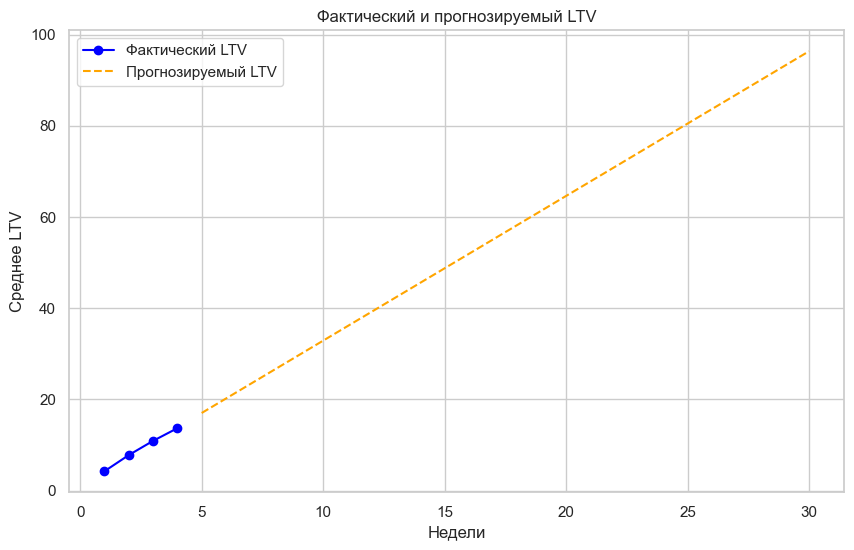

In [29]:
# Визуализация результатов
plt.figure(figsize=(10, 6))

# Кривая фактического LTV
plt.plot(X, y, label='Фактический LTV', color='blue', marker='o')


# Кривая прогнозируемого LTV
plt.plot(weeks_forecast, ltv_forecast, label='Прогнозируемый LTV', color='orange', linestyle='--')

plt.xlabel('Недели')
plt.ylabel('Среднее LTV')
plt.title('Фактический и прогнозируемый LTV')
plt.legend()
plt.show()

Мы видим, что согласно прогнозу восходящая тенденция LTV сохранится и в ближайшие полгода

### 5. Расчет операционного ROMI

Для того, чтобы рассчитать ROMI (возврат на маркетинговые инвестиции), необходимо разделить LTV на CAC (стоимость привлечения клиента), который согласно условиям равен 6$

In [30]:
# Сохраним значение CAC в переменную

cac = 6

# Создадим датафрейм romi на основе имеющегося датафрейма result_grouped
romi = result_grouped.copy()

# Рассчитаем ROMI отдельно для каждой когорты
for week in range(1, 5):
    romi[week] = romi[week] / cac

display (romi)


,1,2,3,4
cohort_number,,,,
1,0.716721,1.347796,1.911256,2.404846
2,0.706535,1.330667,1.861713,2.339349
3,0.733824,1.333832,1.861897,2.348235
4,0.710246,1.283404,1.783448,2.250853
5,0.714831,1.309058,1.845496,2.329169
6,0.712201,1.277366,1.790457,2.249942
7,0.696279,1.272995,1.791688,2.259390
8,0.707680,1.302817,1.817840,2.306158
9,0.673804,1.268677,1.782693,2.246655


Мы видим, что уже со второй недели значение ROMI преодолевает отметку 1 (уровень окупаемости) во всех когортах. 

Теперь визуализируем полученные данные: построим тепловую карту значений ROMI за 4 недели по когортам.

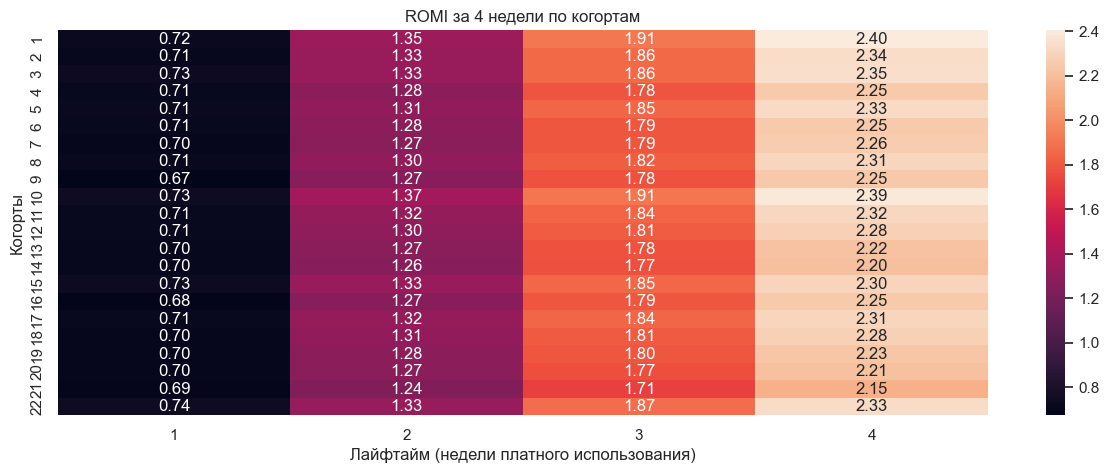

In [31]:
# Построим тепловую карту

fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap (romi, annot = True, fmt = '.2f', ax = ax)

plt.xlabel ('Лайфтайм (недели платного использования)')
plt.ylabel ('Когорты')
plt.title ('ROMI за 4 недели по когортам')
plt.show;

### 6. Прогнозирование ROMI на 6 месяцев

Для прогнозирования ROMI будем использовать тот же подход, что и для прогнозирования LTV ранее

In [32]:
# Преобразование данных в формат, который можно использовать для обучения модели
X = np.arange(1, romi.shape[1] + 1).reshape(-1, 1)  # Временной признак (недели)
y = romi.mean(axis=0).values  # Среднее значение ROMI по когортам

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

# Прогнозирование на полгода вперед
weeks_forecast = np.arange(romi.shape[1] + 1, romi.shape[1] + 27).reshape(-1, 1)
romi_forecast = model.predict(weeks_forecast)

# Оценка качества модели
mse = mean_squared_error(y_test, model.predict(X_test))
print(f"Mean Squared Error on Test Set: {mse}")

Mean Squared Error on Test Set: 0.0024455883295658263


Здесь мы видим еще более близкое к 0 значение MSE, что значит что наш прогноз достаточно точен и может использоваться при принятии управленческих решений

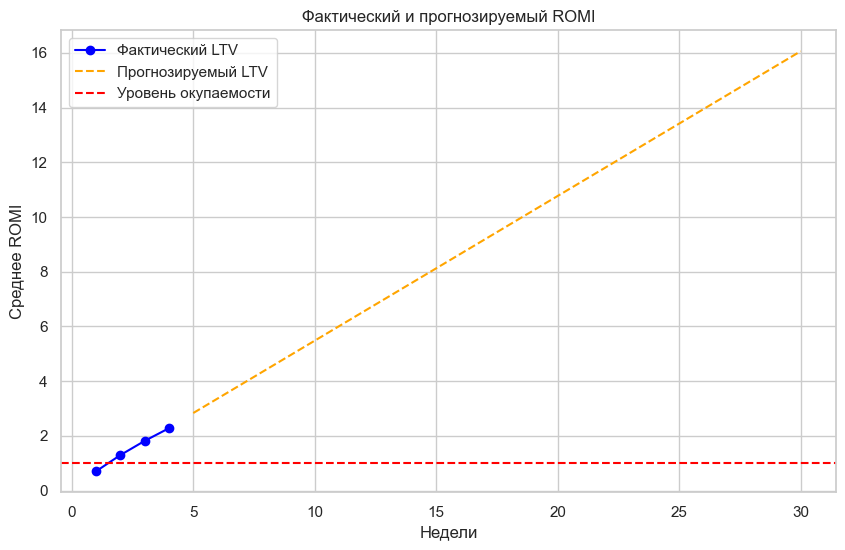

In [33]:
# Визуализация результатов
plt.figure(figsize=(10, 6))

# Кривая фактического ROMI
plt.plot(X, y, label='Фактический LTV', color='blue', marker='o')

# Кривая прогнозируемого ROMI
plt.plot(weeks_forecast, romi_forecast, label='Прогнозируемый LTV', color='orange', linestyle='--')

plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')

plt.xlabel('Недели')
plt.ylabel('Среднее ROMI')
plt.title('Фактический и прогнозируемый ROMI')
plt.legend()
plt.show()

Мы видим, что окупаемость на маркетинговые вложения будет продолжать расти и далее, однако важно понимать, что данный прогноз актуален только при условии, что стоимость привлечения клиента будет такой же, как и в заданном условии

## Задание 2

###  Задача 1. 

Написать 2 SQL запроса для поиска значений среднего и медианы по сумме продажи. Сумму транзакции округляем до целой части. Нельзя использовать стандартные функции среднего и медианы в SQL. Можно использовать только агр функции SUM и COUNT.

**Текст запроса для поиска среднего значения:**

SELECT ROUND(SUM(sale_amount) / COUNT(sale_amount)) AS average_sale_amount  
FROM orders;

**Текст запроса для поиска медианы:**

SELECT sale_amount AS median_sale_amount  
FROM   

(SELECT sale_amount,  
ROW_NUMBER() OVER (ORDER BY sale_amount) AS row_num,  
COUNT(*) OVER () AS total_rows  
FROM orders
    ) as rows_numbered  

WHERE row_num = (total_rows + 1) / 2 OR row_num = (total_rows + 2) / 2;


###  Задача 2. 

Написать SQL-запрос для поиска задублированных в результате ошибки
транзакций.

**Текст запроса:**

SELECT transaction_id,  
FROM purchases    
GROUP BY transaction_id  
HAVING COUNT(*) > 1;


###  Задача 3. 

Написать SQL-запрос для построения воронки перехода из установки в
оформление пробного периода и в покупку платной версии приложения в разрезе
стран. На одного юзера возможна только одно оформление пробного периода и одна
покупка платной версии. Покупка возможна только после истечения срока пробного
периода. На выходе должна получится таблица с колонками “country”, “installs”, “trials”,
“purchases”, “conversion_rate_to_trial”, “conversion_rate_to_purchase”

**Текст запроса:**

SELECT country,   
COUNT (CASE WHEN event_type = 'install' THEN 1 END) AS installs,  
COUNT (CASE WHEN event_type = 'trial' THEN 1 END) AS trials,  
COUNT (CASE WHEN event_type = 'purchase' THEN 1 END) AS purchases,  
COUNT (CASE WHEN event_type = 'trial' THEN 1 END) * 100 / NULLIF (COUNT (CASE WHEN event_type = 'install' THEN 1 END),0) AS conversion_rate_to_trial,  
COUNT (CASE WHEN event_type = 'purchase' THEN 1 END) * 100 / NULLIF (COUNT (CASE WHEN event_type = 'trial' THEN 1 END),0) AS conversion_rate_to_purchase   

FROM events   
GROUP BY country;

## Задание 3

Продуктовый менеджер сформировал гипотезу, что новая версия экрана продаж будет
лучше перформить по сравнению со старой, в связи с тем, что на новом экране продаж
более понятно описаны преимущества платной версии приложения.
Продуктовый менеджер ожидает увеличение уровня конверсии из установки в покупку
платной версии приложения. Приложение тем временем уже очень активно
продвигается на рынке, каждый день привлекается в среднем по 30 000 новых
пользователей, текущий уровень конверсии из установки в покупку 5%.  

Как бы вы предложили проверить данную гипотезу, какие инструменты и тесты бы
использовали в процессе проверки?

**Ответ:**

Поскольку речь идет о потенциальном изменении конверсии, то необходимо использовать количественный метод проверки гипотезы, а именно A/B-тестирование по ряду причин:

1) Данный метод является достаточно гибким: можно сравнить не только конверсию, но и другие метрики. Таким образом можно выявить узкие места в воронке и оптимизировать ее.
2) Можно протестировать изменения на контрольной группе пользователей, а не выкатывать новую версию сразу на всех пользователей (тем более если текущая версия уже активно используется и особенно если текущий показатель конверсии в нише является средним или выше среднего), что позволяет минимизировать риски неправильных решений.
3) A/B-тест - достаточно точный метод маркетинговых исследований, который основан на объективных данных и научном подходе к оценке правильности гипотез
4) По итогам проведенного теста можно не только найти удачные решения, но и выявить неудачные, и в дальнейшем не тратить бюджет на внедрение неэффективных изменений

Что же касается используемых инструментов и тестов, то я бы рекомендовала следующее:

1) перед проведением непосредственно A/B-теста провести A/A-тестирование, чтобы исключить влияние аномалий и выбросов на результаты теста
2) при проведении теста применить попраку Бонферонни, чтобы снизить групповую вероятность ошибки первого типа (ложноположительного результата статистического теста)
3) при анализе результатов теста использовать непараметрический тест Манна-Уитни (особенно, если выборки небольшие по размеру или данные распределены ненормально) или t-тест (если данные нормально распределены, а выборки строго независимы друг от друга)